

# Alineamiento del setup del SLM

Este notebook sirve para ayudar en el alineamiento de los elementos de polarización del setup del SLM. En primer lugar, hay que tener alineada la parte del resto de elementos ópticos comunes (telescopios, SLM, fotodetectores, etc.). Entonces, podemos pasar a alinear P0 y Q0, y encontrar los ejes principales del resto de elementos.

## Preparativos

Importamos los módulos necesarios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from py_pol.jones_matrix import Jones_matrix, Jones_vector

degrees = np.pi/180

from py_lab.daca import DACA, Close_All_DACA

In [2]:
# Crear el objeto de control de la tarjeta de adquisicion de datos
daca = DACA(name="U3")
daca.Open() # Comprobar que no esten cambiados

In [6]:
# Test de que funciona
daca.Get_Signal(verbose=True, return_ref=True, rest_background=False, use_ref=False)

Reference:  4.701663999999999
Signal:  7.113184


(7.113184, 4.701663999999999)

In [8]:
# Medir el background
daca.Get_Signal(is_background=True, verbose=True)

Reference:  0.02934399999999826
Signal:  0.06451199999999879


0.06451199999999879

Ahora, vamos a crear unas pocas funciones que serán necesarias durante los diversos pasos de alineamiento.

In [9]:
def cos2(param, x):
    """Funcion coseno cuadrado."""
    return param[0] + param[1] * np.cos(x - param[2])**2

def error_cos2(param, x, P):
    """Error de la funcion coseno cuadrado."""
    return P - cos2(param, x)

In [10]:
def cos2_2(param, x):
    """Funcion coseno cuadrado."""
    return param[0] + param[1] * np.cos(2*(x - param[2]))**2

def error_cos2_2(param, x, P):
    """Error de la funcion coseno cuadrado."""
    return P - cos2_2(param, x)

In [23]:
def pypol(param, x):
    """Funcion mas compleja."""
    E0 = Jones_vector().general_azimuth_ellipticity(intensity=param[0], azimuth=param[3], ellipticity=param[1])
    Q0 = Jones_matrix().retarder_linear(azimuth=45*degrees+param[4], R=param[2])
    P1 = Jones_matrix().diattenuator_perfect(azimuth=x-angulo_P1)
    E = P1 * Q0 * E0
    return E.parameters.intensity()

def error_pypol(param, x, P):
    """Error de la funcion pypol."""
    return P - pypol(param, x)

In [12]:
def Tomar_Medidas(N=100):
    """Funcion que sirve para tomar medidas angulo-potencia.
    
    Args:
        N (int): Numero maximo de medidas."""
    angulos = np.zeros(N)
    P = np.zeros(N)        
    
    for ind in range(N):
        ang = input('Angulo (en grados)')
        try:
            angulos[ind] = float(ang)
            P[ind] = daca.Get_Signal()
        except:
            if ang.lower() in ('fin', 'end', 'stop'):
                angulos = angulos[:ind]
                P = P[:ind]
                break
            else:
                print('Value {} not accepted'.format(ang))
            
    return angulos*degrees, P

default_bounds = ([0, 0, 0], [10, 10, 180*degrees])

def Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=[3, 2, 0], bounds=default_bounds):
    """Funcion que sirve para analizar las medidas tomadas.
    
    Args:
        angulos (np.ndarray): Angulos a los que se han tomado las medidas.
        P (np.ndarray): Resultado de las medidas.
        fun_err (function): Funcion que calcula el error en los datos.
        fun_plot (function): Funcion a la que deberian ajustar los datos.
        param_0 (array like): Parametros iniciales para el algoritmo de ajuste.
        bounds (2x1 tuple): Limites para el algoritmo de ajuste."""
    # Ajustar
    result = least_squares(fun=fun_err, x0=param_0, args=[angulos, P], bounds=bounds)
    
    # Representar los resultados
    if len(result.x) == 3:
        print('Resultados:\n - Pmin = {:.3f}.\n - DP = {:.3f} V.\n - A_0 = {:.1f} deg.\n - Error: {:.3f}'.format(
            result.x[0], result.x[1], result.x[2] / degrees, result.cost))
    elif len(result.x) == 5:
        print('Resultados:\n - I0 = {:.3f}.\n - Ellipticity_E0 = {:.1f} deg.\n - Retardance_Q0 = {:.1f} deg.\n - Theta_0 = {:.1f} deg.\n - Q0 angle offset = {}\n - Error: {:.3f}'.format(
            result.x[0], np.abs(result.x[1]) / degrees, result.x[2] / degrees, result.x[3] / degrees, result.x[4]/degrees, result.cost))
    
    # Representar el resultado
    plt.figure()
    plt.plot(angulos/degrees, P, '+b', angulos/degrees, fun_plot(result.x, angulos), '--r')
    
    return result.x

## Caracterización de la fuente

Si el expansor de haz está desalineado, va a provocar una polarización muy rara. Para comprobar que no ocurre nada (y de paso caracterizar el estado de polarización del laser) voy a medir la intensidad que atraviesa P1 al girarlo.

In [13]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


Resultados:
 - Pmin = 0.011.
 - DP = 1.550 V.
 - A_0 = 49.1 deg.
 - Error: 0.002


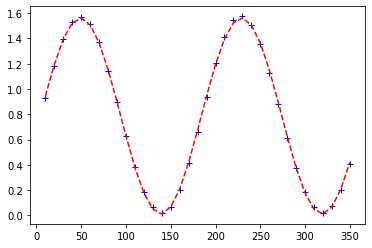

In [14]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [8, 8, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

## Alineamiento de $P_0$

Este es facil. Únicamente con $P_0$ colocado, observando la señal en el fotodiodo. Hay que maximizarla (el eje de P0 coincidirá entonces con el semieje mayor de la polarización de salida del laser). En un sistema que se pueda medir conviene guardar el dato.

In [ ]:
angulo_P0 = 

## Alineamiento de $Q_0$

A continuación, colocamos $P_1$ y buscamos el ángulo para el que se minimiza la potencia. De esta manera, el ángulo de P1 será el del láser $\pm$90º. Guardamos ese angulo para la posteridad (debería estar muy próximo a alguno de los minimos de la curva anterior).

In [ ]:
angulo_min = 320 * degrees

A continuación, colocamos $Q_0$ y la giramos para obtener la máxima potencia. Con eso tendremos la luz lo más circularmente polarizada posible. En un sistema que pueda medirse, se guarda ese valor.

In [ ]:
angulo_Q0 = 

## Alineamiento de $P_1$

Ya podemos alinear $P_1$. Para ello, tenemos que colocar antes de él un polarizador de eje conocido. No necesita ser un polarizador muy bueno, pero su orientacion es muy importante, ya que marcará el sistema de referencia de angulos de aqui en adelante. 

Debemos colocar el polarizador conocido entre $Q_0$ y $P_1$, con el eje de transmisión horizontal. Entonces, medimos de nuevo para varios angulos de $P_1$. Esto nos dará el angulo de origen de $P_1$, y por lo tanto de la iluminación que sale de $Q_0$ si es elíptica.

Experimento: Usé el polarizador de plastico que uso como referencia también para el poalrímetro.

In [16]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


Resultados:
 - Pmin = 0.002.
 - DP = 0.262 V.
 - A_0 = 128.3 deg.
 - Error: 0.000


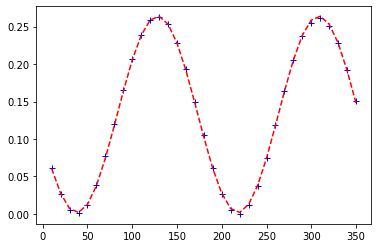

In [17]:
param_0 = [0, 2.5, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [10, 10, 180*degrees])
param_P1 = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

In [18]:
angulo_P1 = 128.3 * degrees

## Caracterización de la iluminación

Vamos a caracterizar la luz que sale de $Q_0$. Para ello retiramos el polarizador de referencia y medimos la potencia rotando $P_1$.

In [19]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


Resultados:
 - Pmin = 0.433.
 - DP = 0.020 V.
 - A_0 = 180.0 deg.
 - Error: 0.000


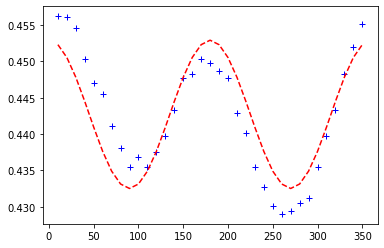

In [20]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [2, 1, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

La curva no es plana, tiene oscilaciones. Esto se debe a que la retardancia de $Q_0$ no es exactamente 90º y, por lo tanto, el ángulo de elipticidad del estado que emerge de ella no es exactamente 45º (0 -45º). Además, al comprobar que ocurre girar $P_1$ 180º, se ve que el valor cambia ligeramente. Esto se debe a que el haz que llega a $Q_0$ No está perfectamente polarizado, sino que es ligeramente elíptico. Vamos a ver si hacemos un ajuste un poquito mejor para obtener estos parámetros.

Resultados:
 - I0 = 0.885.
 - Ellipticity_E0 = 0.2 deg.
 - Retardance_Q0 = 89.9 deg.
 - Theta_0 = 87.1 deg.
 - Q0 angle offset = -2.3376592046156635
 - Error: 0.000


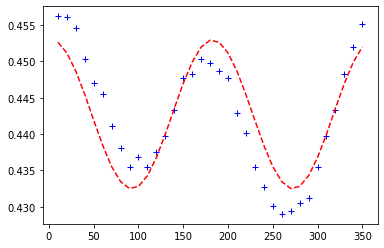

In [24]:
param_0 = [1, 0*degrees, 90*degrees, 180*degrees*np.random.rand(1)[0], 0]
bounds = ([0, -45*degrees, 80*degrees, 0, -10*degrees], [5, 45*degrees, 100*degrees, 180*degrees, 10*degrees])
param_illum2 = Analizar_medidas(angulos, P, fun_err=error_pypol, fun_plot=pypol, param_0=param_0, bounds=bounds)

Ahora vamos a calcular los parámetros de la iluminación tras Q0.

In [26]:
E0 = Jones_vector().general_azimuth_ellipticity(intensity=param_illum2[0], azimuth=0, ellipticity=param_illum2[1])
Q0 = Jones_matrix().retarder_linear(azimuth=45*degrees, R=param_illum2[2])
Eillum = Q0 * E0
Eillum.name = "Iluminacion tras Q0"
illum_el = Eillum.parameters.azimuth(verbose=True)
illum_az = Eillum.parameters.ellipticity_angle(verbose=True)

The azimuth of Iluminacion tras Q0 is (deg.):
89.99999999999976

The ellipticity angle of Iluminacion tras Q0 is (deg.):
44.788059742259925



Los datos no son muy buenos así que este ajuste no da demasiada información. De hecho es muy muy similar al ajuste al coseno cuadrado. Eso nos da una indicacion de lo buenos que son los polarizadores y retardadores.

## Alineamiento de $P_2$

Para alinear $P_2$, quitamos el polarizador de eje conocido y colocamos $P_2$.Colocamos $P_1$ con azimut = 0, ya que lo hemos medido antes. De esa manera, podemos encontrar facilmente el angulo de origen de $P_2$. Si colocamos algún elemento detrás del SLM, a partir de este momento debemos colocar un espejo delante para evitar que afecte a las medidas.

In [37]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) end


Resultados:
 - Pmin = 0.010.
 - DP = 2.386 V.
 - A_0 = 71.9 deg.
 - Error: 0.002


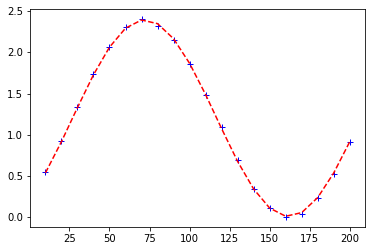

In [38]:
param_0 = [3, 2, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [10, 10, 180*degrees])
param_P2 = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

In [39]:
# Calcular parametros
az_P2 = param_P2[2]

print('P2:\n - Angulo de origen = {:.0f} deg'.format(az_P2/degrees))

P2:
 - Angulo de origen = 72 deg


## Alineamiento de $Q_1$

Para alinear $Q_1$, se debe colocar ambos polarizadores con azimut = 0. Entonces, se rotará $Q_1$ entre 0 y 90º.

In [40]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 15
Angulo (en grados) 20
Angulo (en grados) 25
Angulo (en grados) 30
Angulo (en grados) 35
Angulo (en grados) 40
Angulo (en grados) 45
Angulo (en grados) 50
Angulo (en grados) 55
Angulo (en grados) 60
Angulo (en grados) 65
Angulo (en grados) 70
Angulo (en grados) 75
Angulo (en grados) 80
Angulo (en grados) 85
Angulo (en grados) 90
Angulo (en grados) 95
Angulo (en grados) 100
Angulo (en grados) 105
Angulo (en grados) 110
Angulo (en grados) end


Resultados:
 - Pmin = 1.019.
 - DP = 1.116 V.
 - A_0 = 85.3 deg.
 - Error: 0.004


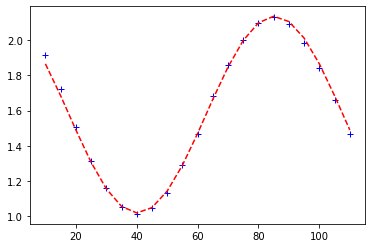

In [45]:
param_0 = [1, 1.2, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [2, 2, 180*degrees])
param_Q1 = Analizar_medidas(angulos, P, fun_err=error_cos2_2, fun_plot=cos2_2, param_0=param_0, bounds=bounds)

Este valor corresponde al alineamiento de uno de los dos ejes con el eje de transmisión de los polarizadores. Para determinar si se trata del eje rápido o el lento, hay que hacer una nueva medida. Para ello, se coloca una lámina de cuarto de onda de eje rápido conocido cerca de la posición de $Q_2$ a 45º. Entonces, se observa la potencia en el ángulo de cero encontrado previamenta +45º y -45º (0 +135º si esto nos lleva por debajo de 0º). La posición que de MAYOR potencia corresponderá a un azimut de 45º (ver sección final para entender esto).

In [49]:
angulos2, P2 = Tomar_Medidas()

Angulo (en grados) 40
Angulo (en grados) 130
Angulo (en grados) end


In [50]:
print(angulos2/degrees, P2, sep='\n')

[ 40. 130.]
[0.13629403 1.68711656]


In [52]:
# Calcular parametros
az_Q1 = param_Q1[2]
# az_Q1 = param_Q1[2] + 90*degrees

print('Q1:\n - Angulo de origen = {:.0f} deg'.format(az_Q1/degrees))

Q1:
 - Angulo de origen = 85 deg


## Alineamiento de $Q_2$

En esta ocasión, no vamos a hacer todas las medidas con $Q_1$. Primero la retiro, y dejo solo un retardador, $Q_2$. Entonces, despues de tomar la curva mido los dos puntos en los que obtenga minimo para discriminar.

In [53]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 15
Angulo (en grados) 20
Angulo (en grados) 25
Angulo (en grados) 30
Angulo (en grados) 35
Angulo (en grados) 40
Angulo (en grados) 45
Angulo (en grados) 50
Angulo (en grados) 55
Angulo (en grados) 60
Angulo (en grados) 65
Angulo (en grados) 70
Angulo (en grados) 75
Angulo (en grados) 80
Angulo (en grados) 85
Angulo (en grados) 90
Angulo (en grados) 95
Angulo (en grados) 100
Angulo (en grados) 105
Angulo (en grados) end


Resultados:
 - Pmin = 1.069.
 - DP = 1.151 V.
 - A_0 = 0.0 deg.
 - Error: 0.001


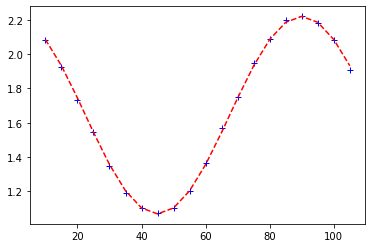

In [54]:
param_0 = [3, 2, 0*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [10, 10, 90*degrees])
param_Q2 = Analizar_medidas(angulos, P, fun_err=error_cos2_2, fun_plot=cos2_2, param_0=param_0, bounds=bounds)

In [1]:
angulos2, P2 = Tomar_Medidas()

NameError: name 'Tomar_Medidas' is not defined

In [56]:
print(angulos2/degrees, P2, sep='\n')

[ 45. 135.]
[0.1065449  1.86280488]


In [193]:
# Calcular parametros
az_Q2 = param_Q2[2]
# az_Q2 = param_Q2[2] + 90*degrees

print('Q2:\n - Angulo de origen = {:.1f} deg'.format(az_Q2/degrees))

Q2:
 - Angulo de origen = 0.2 deg


## Angulo de cero de $Q_i$

Cuando se mide la intensidad que atraviesa el sistema formado por:

$S_1$ = $P_1(0)$ -> $Q_i(\theta)$ -> $P_2(0)$.

Podemos determinar el angulo de cero de $Q_i$ con una incertidumbre entre ese valor y $\pm$90º (ya que en el recorrido de 180º del retardador encontramos dos maximos, cuando los ejes del retardador se alinean con los del polarizador, pero no podemos determinar si el eje rapido se alinea con los ejes de transmisión o extinción). Para ello, hay que volver a medir colocando un retardador de ejes conocidos. 

Teóricamente, podemos medir el angulo de cero de $Q_i$ midiendo la intensidad en el sistema:

$S_2$ = $P_1(0)$ -> $Q_i(\theta)$ -> $Q_{ref}(45\deg)$ -> $P_2(0)$.

Sin embargo, si el angulo de alguno de los elementos que se mantienen fijos no es constante, o los ángulos de 0 y 45º no son precisos, el ajuste a un $cos^2(x)$ fallará, ya que la intensidad no seguirá esa tendencia (los máximos se acercan o se alejan). Por lo tanto, la mejor solución es medir la curva en el sistema 1, y después únicamente medir la intensidad en el sistema 2 para los ángulos de $Q_i$ en que obtengamos mínimos de intensidad (en realidad medimos para los máximos, ver la siguiente seccion). De esa manera, si en $S_2$ obtenemos un mínimo, $Q_i$ y $Q_{ref}$ tienen los ejes alineados:

In [9]:
from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix, degrees, np

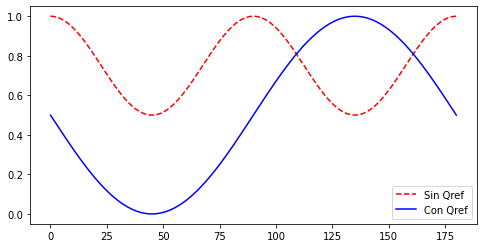

In [51]:
angulos = np.linspace(0, 180, 181)*degrees
E0 = Jones_vector().linear_light() # Pol circular a traves de P1
Q1 = Jones_matrix().quarter_waveplate(azimuth=angulos)
Qref = Jones_matrix().quarter_waveplate(azimuth=45*degrees)
P2 = Jones_matrix().diattenuator_perfect()

E1 = P2 * Q1 * E0
I1 = E1.parameters.intensity()
E2 = P2 * Qref * Q1 * E0
I2 = E2.parameters.intensity()

plt.figure(figsize=(8,4))
plt.plot(angulos/degrees, I1, 'r--')
plt.plot(angulos/degrees, I2, 'b')
plt.legend(('Sin Qref', 'Con Qref'))

## Efecto del espejo

El espejo que hay tras $Q_1$ cambia el estado de polarización de la siguiente manera:

* $\phi -> 180º - \phi$
* $\chi -> -\chi$

Puesto que al alinear $P_2$ usamos $P_1$ con un azimut de 0º, no influye. Pero si influye a la hora de alinear las láminas retardadoras. Por ese motivo, es necesario mirar el valor de intensidad máximo en lugar de mínimo:

The intensity of J * J @ 45.00 deg * J * J * E is (a.u.):
The mean value is 0.5000000000000001 +- 0.3525753710417015


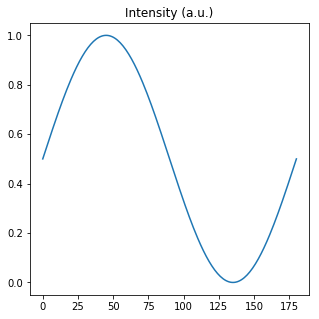

In [11]:
E0 = Jones_vector().linear_light() # Pol circular a traves de P1
Q1 = Jones_matrix().quarter_waveplate(azimuth=np.linspace(0, 180, 181)*degrees)
Qref = Jones_matrix().quarter_waveplate(azimuth=45*degrees)
M = Jones_matrix().mirror()
P2 = Jones_matrix().diattenuator_perfect()
E = P2 * Qref * M * Q1 * E0
I = E.parameters.intensity(draw=True)